In [1]:
import warnings
warnings.simplefilter(action='ignore',)

import os # Kernel dies when plotting after importing torch
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import train_test_split

import torch 
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, TensorDataset
from tqdm.auto import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu') # Note that gpu is not faster
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

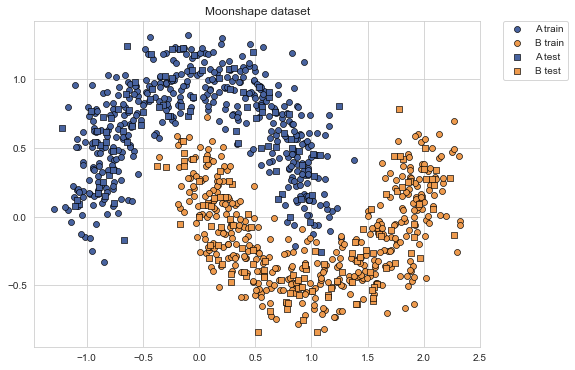

In [2]:
X,y = datasets.make_moons(n_samples=1000, noise=0.16, random_state=7)
train_x, test_x, train_y, test_y = train_test_split(X, y, random_state=7,test_size=1/5)

sns.set_style("whitegrid")
plt.figure(figsize=(8,6))

plt.scatter(
    train_x[np.where(train_y[:] == 0), 0], train_x[np.where(train_y[:] == 0), 1],
    marker="o", color="#4863A0", edgecolors="k", linewidths=0.64, label="A train")

plt.scatter(
    train_x[np.where(train_y[:] == 1), 0], train_x[np.where(train_y[:] == 1), 1],
    marker="o", color="#EE9A4D", edgecolors="k", linewidths=0.64, label="B train")

plt.scatter(
    test_x[np.where(test_y[:] == 0), 0], test_x[np.where(test_y[:] == 0), 1],
    marker="s", color="#4863A0", edgecolors="k", linewidths=0.64, label="A test")

plt.scatter(
    test_x[np.where(test_y[:] == 1), 0], test_x[np.where(test_y[:] == 1), 1],
    marker="s", color="#EE9A4D", edgecolors="k", linewidths=0.64, label="B test")

plt.legend(bbox_to_anchor=(1.05,1), loc="upper left", borderaxespad=0.0)

plt.title("Moonshape dataset")
plt.show()

In [3]:
train_x = torch.from_numpy(train_x).to(torch.float32)
train_y = torch.from_numpy(train_y).to(torch.float32)
test_x = torch.from_numpy(test_x).to(torch.float32)
test_y = torch.from_numpy(test_y).to(torch.float32)

train_dataset = TensorDataset(train_x, train_y)
test_dataset = TensorDataset(test_x, test_y)

train, valid = random_split(train_dataset,[600,200])

In [4]:
NUM_EPOCHS = 1000
EARLY_STOP = 100
NUM_CLASS = 2
BATCH_SIZE = 10
LEARN_RATE = 0.001

In [5]:
train_loader = torch.utils.data.DataLoader(dataset=train,
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True)

valid_loader = torch.utils.data.DataLoader(dataset=valid,
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=BATCH_SIZE, 
                                          shuffle=False)

In [6]:
class NN_model(torch.nn.Module):
    def __init__(self):
        super(NN_model, self).__init__()
        
        self.layer = torch.nn.Sequential(torch.nn.Linear(2, 32),
                                         torch.nn.ReLU(),
                                         torch.nn.Linear(32, 16),
                                         torch.nn.ReLU(),
                                         torch.nn.Linear(16, 1),
                                         torch.nn.Sigmoid())
        
    def forward(self, x): return self.layer(x)

model = NN_model().to(device)

cost_func = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARN_RATE)    
print(model)

NN_model(
  (layer): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


In [7]:
LOSS,VAL_LOSS = [],[]

early_step, total_step = 0, len(train_loader)
min_valid_loss = np.inf

for epoch in range(NUM_EPOCHS):    
    train_acc,train_total,valid_acc,valid_total = 0,0,0,0
    train_loss,valid_loss = 0.0,0.0
    
    for datas, labels in train_loader:
        datas = datas.to(device)
        labels = labels.to(device)
      
        outputs = model(datas)
        loss = cost_func(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    for datas, labels in valid_loader:
        datas = datas.to(device)
        labels = labels.to(device)
        
        outputs = model(datas)
        loss = cost_func(outputs, labels)
        valid_loss += loss.item() 

    LOSS.append(train_loss)
    VAL_LOSS.append(valid_loss)
    
    if (epoch+1) % 50 == 0: print('Epoch [{}/{}] train_loss: {:6.3f} | valid_loss: {:6.3f}'.format(epoch+1, NUM_EPOCHS ,(train_loss /len(train_loader)),(valid_loss /len(valid_loader))))
    
    if min_valid_loss > valid_loss:
        early_step, min_valid_loss = 0, valid_loss     
        torch.save(model.state_dict(), 'saved_model.pth')
    else:
        early_step += 1
        if early_step > EARLY_STOP:
            print(f"\nNo improvment {EARLY_STOP} consecutive epochs, early stopping.")
            break

Epoch [50/1000] train_loss:  0.248 | valid_loss:  0.247
Epoch [100/1000] train_loss:  0.247 | valid_loss:  0.250
Epoch [150/1000] train_loss:  0.246 | valid_loss:  0.247
Epoch [200/1000] train_loss:  0.246 | valid_loss:  0.248
Epoch [250/1000] train_loss:  0.247 | valid_loss:  0.246

No improvment 100 consecutive epochs, early stopping.


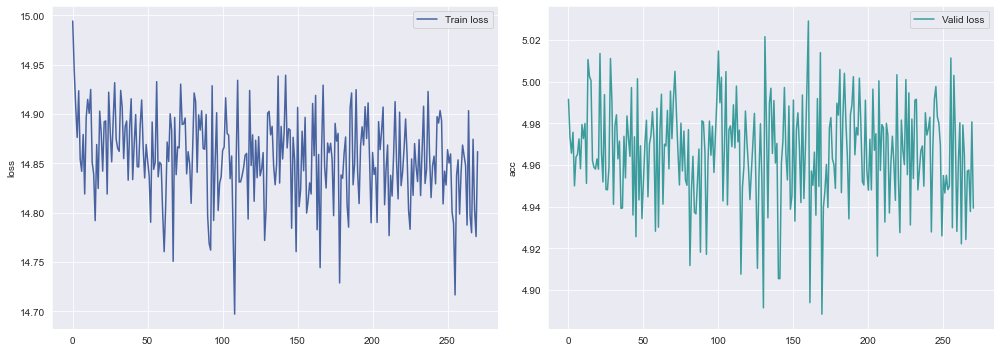

In [8]:
sns.set_style("darkgrid")
fig, ax = plt.subplots(1, 2, figsize=(14,5))
ax[0].plot(LOSS, label="Train loss", color="#4863A0")
ax[0].set_ylabel('loss')
ax[0].legend(loc="upper right")

ax[1].plot(VAL_LOSS, label="Valid loss", color="#3B9C9C")
ax[1].set_ylabel('acc')
ax[1].legend(loc="upper right")

plt.tight_layout()
plt.show()

In [9]:
model = NN_model().to(device)
model.load_state_dict(torch.load('saved_model.pth'))
model.eval()  

test_x = test_x.to(device)
predict = model(test_x)
predict_label = np.where(predict.to(torch.device("cpu")).detach().numpy()<0.5, 0, 1)
test_accuracy = np.sum(test_y.reshape(-1,1).numpy()==predict_label) / len(test_y)
print("\nTest Accuracy {:.2f}".format(test_accuracy))


Test Accuracy 0.97


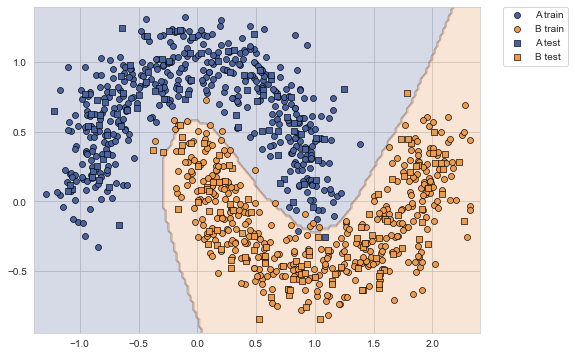

In [10]:
x_min, x_max = X[:, 0].min()-0.1, X[:, 0].max()+0.1
y_min, y_max = X[:, 1].min()-0.1, X[:, 1].max()+0.1
grid = min(x_max - x_min, y_max - y_min) / 100

XX, YY = np.meshgrid(np.arange(x_min, x_max, grid), np.arange(y_min, y_max, grid))
meshgrid_ = np.hstack((XX.ravel().reshape(-1,1), YY.ravel().reshape(-1,1)))

meshgrid_features = torch.from_numpy(meshgrid_).float().to(device)
meshgrid_colors = model(meshgrid_features)

clf = np.where(meshgrid_colors.to(torch.device("cpu")) < 0.5,0,1)
ZZ = clf.reshape(XX.shape)

sns.set_style("whitegrid")
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#4863A0","#EE9A4D"])

test_x = test_x.to(torch.device("cpu"))

plt.figure(figsize=(8,6))
plt.contourf(XX, YY, ZZ, cmap=cmap, alpha=0.24)
plt.scatter(
    train_x[np.where(train_y[:] == 0), 0], train_x[np.where(train_y[:] == 0), 1],
    marker="o", color="#4863A0", edgecolors="k", linewidths=0.64, label="A train")

plt.scatter(
    train_x[np.where(train_y[:] == 1), 0], train_x[np.where(train_y[:] == 1), 1],
    marker="o", color="#EE9A4D", edgecolors="k", linewidths=0.64, label="B train")

plt.scatter(
    test_x[np.where(test_y[:] == 0), 0], test_x[np.where(test_y[:] == 0), 1],
    marker="s", color="#4863A0", edgecolors="k", linewidths=0.64, label="A test")

plt.scatter(
    test_x[np.where(test_y[:] == 1), 0], test_x[np.where(test_y[:] == 1), 1],
    marker="s", color="#EE9A4D", edgecolors="k", linewidths=0.64, label="B test")

plt.legend(bbox_to_anchor=(1.05,1), loc="upper left", borderaxespad=0.0)
plt.show()